In [1]:
from CoLoRe_corrf_analysis.plot_methods import Plots
from CoLoRe_corrf_analysis.file_funcs import FileFuncs
from CoLoRe_corrf_analysis.fitter import Fitter
from CoLoRe_corrf_analysis.cf_helper import CFComputations
from CoLoRe_corrf_analysis.read_colore import ComputeModelsCoLoRe

from scipy.interpolate import interp1d
from scipy import ndimage

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import os
_ = Path('.').resolve()
os.chdir('/global/homes/c/cramirez/Work/QSO_clustering_analysis/modules')
from data_readers import AbacusOut, eBossOut
os.chdir(_)

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
corrf_files = Path('/global/cscratch1/sd/cramirez/QSO_clustering_analysis/corrf_compare_abacus/')
colore_boxes = corrf_files.parent / 'CoLoRe_boxes' 

In [6]:
theory_path = colore_boxes / 'compare_abacus' / 'logn_bias3_multibias_try4'
assert theory_path.is_dir()

theory = ComputeModelsCoLoRe(
    box_path = theory_path,
    source = 5,

    apply_lognormal = False)

In [7]:
zmin = 1.2
zmax = 1.6
rsd = True

In [8]:
def get_boxes(path, rsd=rsd, rmin=0.1, rmax=200, N_bins=41, zmin=zmin, zmax=zmax, nside=2):
    return FileFuncs.mix_sims(
        FileFuncs.get_full_path(path,
                                rsd=rsd, rsd2=None, 
                                rmin=rmin, rmax=rmax, N_bins=N_bins,
                                zmin=zmin, zmax=zmax, nside=2)
    )

In [9]:
in_b_logn = 3.11
in_b_lpt = 2.4

In [11]:
class NotebookHelper:
    def __str__(self):
        return self.label
    
lognormal = NotebookHelper()
lognormal.path = corrf_files / str(in_b_logn) / 'logn_bias3_multibias'
lognormal.label = 'lognormal'
lognormal.bias_model = 3
lognormal.dens_type = 0
lognormal.boxes = get_boxes(lognormal.path)
lognormal.theory = theory
lognormal.color = 'navy'
lognormal.error_rescaling = 1
    
lpt = NotebookHelper()
lpt.path = corrf_files / str(in_b_lpt) / '2lpt_bias3_multibias'
lpt.label = '2lpt'
lpt.bias_model = 3
lpt.dens_type = 2
lpt.boxes = get_boxes(lpt.path)
lpt.theory = theory
lpt.color = 'red'
lpt.error_rescaling = 1

abacus = NotebookHelper()
abacus.path = '/global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/Clustering/CubicBox/QSO/AbacusSummit_base_c000/z1.400/2PCF'
abacus.bias_model = None
abacus.dens_type = None
abacus.boxes = [AbacusOut(i) for i in Path('/global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/Clustering/CubicBox/QSO/AbacusSummit_base_c000/z1.400/2PCF').glob('*_RSD.dat')]
abacus.theory = theory
abacus.color = 'silver'
abacus.label = 'abacus'
abacus.error_rescaling = 1 # I won't consider re-scaling of errors in abacus

analyses = [lognormal, lpt]

for analysis in analyses:
    assert analysis.path.is_dir()

In [12]:
pole_string = {0: 'Monopole', 2: 'Quadrupole'}

In [13]:
%matplotlib widget

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
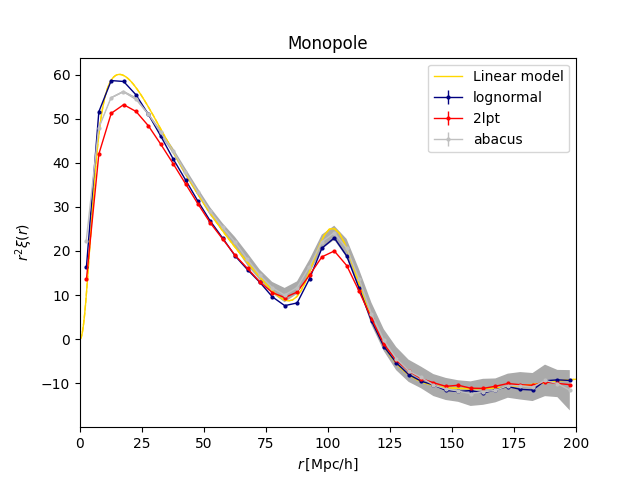

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
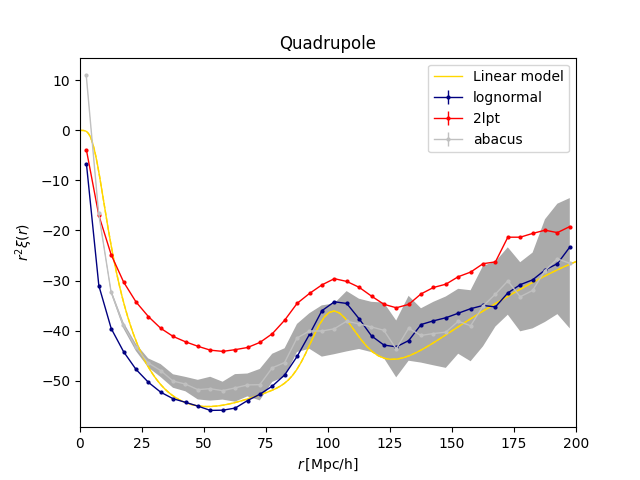

In [14]:
for pole in 0, 2:
    fig, ax = plt.subplots()

    for analysis in analyses + [abacus]:
        analysis.z = analysis.theory.get_zeff(zmin, zmax)
        Plots.plot_data(pole, analysis.boxes, error_rescaling=0, jacknife=True, ax=ax, plot_args=dict(fmt='-', marker='o', markersize=2, lw=1, c=analysis.color, label=str(analysis)))
    Plots.plot_data(pole, abacus.boxes, error_rescaling=np.sqrt(1)*3, jacknife=True, ax=ax, plot_args=dict(alpha=0.3), shaded_errors=True)
    Plots.plot_theory(pole, z=analysis.z, theory=theory, bias=2.0381347426902927, ax=ax, rsd=rsd, plot_args=dict(label='Linear model', lw=1, ls='-', c='gold'))
    ax.set_title(pole_string[pole])
    ax.set_xlim(0, 200)
    ax.legend()

# Fit of bias

In [15]:
from lmfit import Parameters, minimize

In [16]:
for analysis in analyses + [abacus]:
    _bias = analysis.theory.bias(analysis.z)
    analysis.fitter_bias = Fitter(boxes=analysis.boxes, z=analysis.z, theory=analysis.theory, poles=[0], rsd=rsd, smooth_factor0=1, bias0=_bias, rmin={0:30, 2:30}, rmax={0:80, 2:80})
    analysis.fitter_bias.run_fit(free_params=['bias'])

In [17]:
def fit_factor_bias(data_r, data_xi, model, data_xi_err=None, rmin=10, npole=0):
    params = Parameters()
    params.add('bias', value=1, min=0, vary=True)
    
    mask = data_r > rmin
    data_r = data_r[mask]
    data_xi = data_xi[mask]
    
    
    def residual(params):
        model_interp = interp1d(model.r, model.get_npole(npole, z=1.52, rsd=True, bias=params['bias'].value))                                
        if data_xi_err is None:
            return data_xi - model_interp(data_r)
        else:
            return (data_xi-model_interp(data_r))/data_xi_err
        
    return minimize(residual, params)

In [18]:
def get_bias_from_survey(survey, npole):
    data_r = survey.r
    data_xi = survey.compute_npole(npole)
    
    out = fit_factor_bias(data_r, data_xi, theory_2lpt, npole=npole)
    return out

In [19]:
for analysis in analyses + [abacus]:
    print(analysis.label)
    print(analysis.fitter_bias.out.params['bias'].value)

lognormal
1.9887241449036668
2lpt
1.9538794492253038
abacus
2.0381347421422977


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
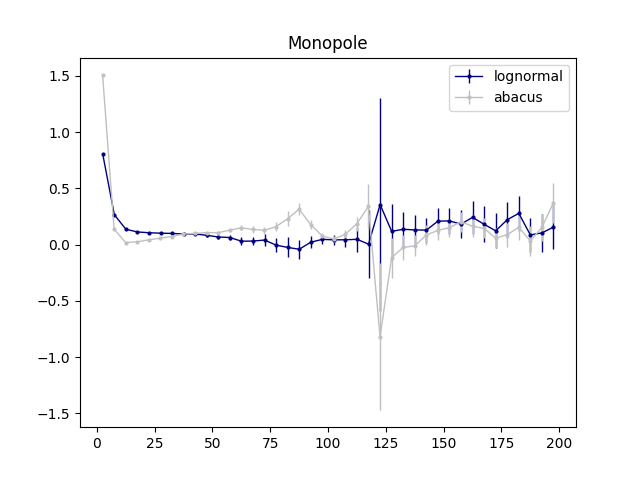

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
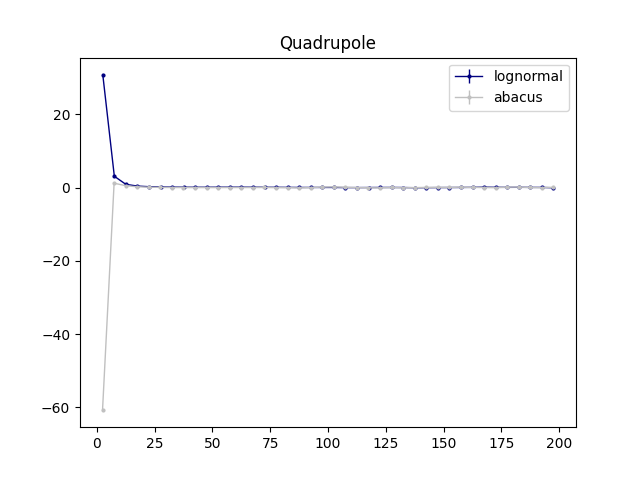

In [20]:
for pole in 0,2:
    fig, ax = plt.subplots()

    for analysis in [lognormal] + [abacus]:
        _xi, _xierr = Plots.get_xi(pole, analysis.boxes)
        _r = analysis.boxes[0].savg
        _rth = theory.r
        _xith = theory.get_npole(pole, z=1.52, rsd=True, bias = analysis.fitter_bias.out.params['bias'].value)

        thinterp = interp1d(_rth, _xith)
        _xithinterp = thinterp(_r)
        ax.errorbar(_r, _xi/_xithinterp-1, _xierr/_xithinterp, c=analysis.color, label=str(analysis), fmt='-', marker='o', markersize=2, lw=1,)

    for _survey in []:
        _r = _survey.r
        _xi = survey.compute_npole(pole)
        _rth = theory.r
        _xith = theory.get_npole(pole, z=1.52, rsd=True, bias=_survey.best_bias)    

        thinterp = interp1d(_rth, _xith)
        _xithinterp = thinterp(_r)
        ax.plot(_survey.r, _xi/_xithinterp-1, c=survey.color, ls='--', lw=1, label=str(survey))
        ax.hlines(0, 0, 200, lw=1, color='k')
    ax.legend()
    ax.set_title(pole_string[pole])